# Classyfing YouTube videos using tags

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from tag_handler import *

In [32]:
from cvs_reader import *
from vocab import *
from dataframe_creator import create_seperate_columns, create_listed_columns

# Get dataframes with tags and category_id as columns
ca_csvpath = '/content/CAvideos.csv'
us_csvpath = '/content/USvideos.csv'
gb_csvpath = '/content/GBvideos.csv'

youtube_dfs = [load_dataframe(ca_csvpath, ['tags', 'category_id'])]
youtube_dfs += [load_dataframe(us_csvpath, ['tags', 'category_id'])]
youtube_dfs += [load_dataframe(gb_csvpath, ['tags', 'category_id'])]

# Concat three dataframes into one
tab_dataframe = pd.concat(youtube_dfs, ignore_index=True)
tab_dataframe = tab_dataframe.dropna()
tab_dataframe.head(100)

,tags,category_id
0,Eminem|Walk|On|Water|Aftermath/Shady/Interscop...,10
1,plush|bad unboxing|unboxing|fan mail|idubbbztv...,23
2,racist superman|rudy|mancuso|king|bach|racist|...,23
3,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,24
4,edsheeran|ed sheeran|acoustic|live|cover|offic...,10
5,#DramaAlert|Drama|Alert|DramaAlert|keemstar|yo...,25
6,Funny Moments|Montage video games|gaming|Vanos...,23
7,SHANtell martin,22
8,logan paul vlog|logan paul|logan|paul|olympics...,24
9,God|Sheldon Cooper|Young Sheldon,22


In [33]:
# Remove 'none' values from dataframe
junk = tab_dataframe[tab_dataframe['tags']=='[none]']
tab_dataframe = pd.concat([tab_dataframe, junk, junk]).drop_duplicates(keep=False)
tab_dataframe

,tags,category_id
5,#DramaAlert|Drama|Alert|DramaAlert|keemstar|yo...,25
13,punjabi songs|punjabi bhangra|punjabi music|pu...,10
18,Rooster Teeth|RT|animation|television|filmmaki...,1
24,80s music|80s songs|madonna|DO COLLEGE KIDS KN...,24
26,Industrial Fan|Industrial Fan Destruction|Thro...,24
28,PhillyD|Philly D|Vloggity|The Philip DeFranco ...,22
31,rhett and link|good mythical more|rhett and li...,24
36,Achievement Hunter|AH|video game|gaming|game|g...,20
38,sugar pine 7|steven suptic|autumn|sick|parker|...,24
39,danny duncan|danny duncan 69|kevin|danny dunca...,23


In [0]:
# Spliting dataframe into several dfs based on category_id
dfs = [x for _, x in tab_dataframe.groupby('category_id')]

# deleting 3 categories (29, 30, 43) beacause of lack of frequency
del dfs[14:17]

In [35]:
from sklearn.utils import resample

resampled_dfs = []
for df in dfs:
    resampled_dfs += [resample(df, n_samples=4000)]

# Resampling datas to make them balanced
tab_dataframe = pd.concat(resampled_dfs, axis=0, ignore_index=True)
tab_dataframe

,tags,category_id
0,战争片|催泪片|感人|感动|温馨|爱情片|几分钟看电影|几分钟说电影|几分钟讲电影|影视解说...,1
1,战争片|催泪片|感人|感动|温馨|爱情片|几分钟看电影|几分钟说电影|几分钟讲电影|影视解说...,1
2,Brother|Sister|Prison|Madtown|Madtown trailer|...,1
3,커트러셀|브레이크다운|breakdown|영화|소개|영화 소개|스릴러|스릴러 영화,1
4,glitchtale|episode 5|my promise|my|promise|und...,1
5,Star Wars Empire|Star Wars|EWW Empire|The Last...,1
6,Senselet|Senselet 34|Zemen|mogachoch|welafen|b...,1
7,avengers infinity war|avengers infinity war ca...,1
8,a boogie|nonchalant|official|audio|a boogie wi...,1
9,gingerpale|gingerpale song|gingerpale theme so...,1


In [0]:
vocab = get_tags_vocab(tab_dataframe)
voc_di = get_tags_vocab_as_dict(vocab)

In [37]:
max_of_tags = 25

tab_dataframe = create_seperate_columns(tab_dataframe, max_of_tags, 'tags')
tab_dataframe

,category_id,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24
0,1,战争片,催泪片,感人,感动,温馨,爱情片,几分钟看电影,几分钟说电影,几分钟讲电影,影视解说,电影解说,美女,女神,少女,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
1,1,战争片,催泪片,感人,感动,温馨,爱情片,几分钟看电影,几分钟说电影,几分钟讲电影,影视解说,电影解说,美女,女神,少女,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
2,1,Brother,Sister,Prison,Madtown,Madtown trailer,Madtown movie,2018,Charles Moore,Milo Ventimiglia,Rachel Melvin,Amanda Aday,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
3,1,커트러셀,브레이크다운,breakdown,영화,소개,영화 소개,스릴러,스릴러 영화,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
4,1,glitchtale,episode 5,my promise,my,promise,undertale,series,animated,animation,camila,cuevas,betty,bete,noire,frisk,asgore,toriel,gaster,undyne,full,episode,papyrus,sans,notags,notags
5,1,Star Wars Empire,Star Wars,EWW Empire,The Last Jedi,EGA Empire Strikes Back,EWW Star Wars,EWW The Last Jedi,CinemaWins,Cinema Wins,Ep V,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
6,1,Senselet,Senselet 34,Zemen,mogachoch,welafen,betoch,Ethiopian film,Temesgen Afework,Tewdros legesse,Mela productions,Hollyland Pictures,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
7,1,avengers infinity war,avengers infinity war cast,funny moments,avengers,avengers funny,avengers play family feud,jimmy kimmel,jimmy kimmel family feud avengers,avengers infinity war cast funny moments,avengers infinity war cast funny,chris hemsworth funny,chris pratt funny,avengers infinity war cast play,family feud,avengers play,mark ruffalo funny,play,games,quiz,marvel quiz,know nothing,infinity war cast,infinity war cast play,infinity war cast funny,fun
8,1,a boogie,nonchalant,official,audio,a boogie wit da hoodie,atlantic records,hip hop,rap,r&B,new york,a boogie - nonchalant,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
9,1,gingerpale,gingerpale song,gingerpale theme song,gingerpale theme music,gingerpale ukulele,gingerpale ukelele song,nevercake theme song,nevercake song,nevercake ukulele,gingerpale collab,nevercake collab,nevercake gingerpale,gingerpale nevercake,nevercake ginger,ginger theme song,animator song,animator theme,notags,notags,notags,notags,notags,notags,notags,notags


In [0]:
future_df = []
col_row_dict = {}
# We only use 1/4 of the dataset!
first_half_df = tab_dataframe[:28000]
second_half_df = tab_dataframe[28000:]

In [0]:
for i in range(0, 28000):
    for col in first_half_df.columns:
        if col == 'category_id':
            col_row_dict.update({'category_id':first_half_df[col][i]})
        else:
            col_row_dict.update({'{}'.format(first_half_df[col][i]):1.0})
    future_df.append(col_row_dict)
    col_row_dict = {}

In [0]:
for i in range(28000, 56000):
    for col in second_half_df.columns:
        if col == 'category_id':
            col_row_dict.update({'category_id':second_half_df[col][i]})
        else:
            col_row_dict.update({'{}'.format(second_half_df[col][i]):1.0})
    future_df.append(col_row_dict)
    col_row_dict = {}

In [10]:
final_dataframe = pd.DataFrame(future_df)
final_dataframe.fillna(0.0, inplace = True)
from input_generator import load_dataset_with_lables
final_dataframe.head()

,category_id,tag_,tag_ 'Gandarrappido: The Revenger Squad,tag_ 070118 💖,tag_ 080118 💖,tag_ 101217 💚,tag_ 140118 💖,tag_ 150118 💖,tag_ 171217 💚,tag_ 261117 💚,tag_ 271117 💚,tag_ Adults React: Gaming,tag_ Châu Giang - Kim Hải,tag_ Chí Hùng - Kim Dung,tag_ Chí Vinh - Lê Huỳnh,tag_ Eastern Conference Semifinals: Raptors (1) vs. Cavaliers (4),tag_ Full Video Out on 9th March,tag_ Ginni Kapoor,tag_ Harjeeta,tag_ Himanshi Khurana,tag_ Hồng Phóng - Hồng Nhung,tag_ Kim Trọng - Kiều Khanh,tag_ Latest Songs 2018,tag_ Lokdhun Punjabi,tag_ MMFF 2017,tag_ Minh Luân - Kim Thoa,tag_ Minh Quận - Thụy Kha,tag_ Mạnh Định - Thị Ý,tag_ NBA on TNT,tag_ New Punjabi Songs 2018,tag_ New Songs 2018,tag_ Official Music Video,tag_ Official Trailer 2,tag_ Overwatch,tag_ PTR Hero Changes,tag_ Quang Sử - Trần Thùy,tag_ Quốc Thới - Mỹ Hiền,tag_ Rudy Mancuso,tag_ TOP 30 Chants de Noel Americain 2018,tag_ Teaser,...,tag_태일,tag_테니스 샌드그렌 테니스,tag_테니스영상,tag_텐,tag_텐데,tag_트와이스,tag_트와이스 Heart Shaker,tag_트와이스 MV,tag_트와이스 Merry Happy,tag_트와이스 What is Love,tag_트와이스 What's Love,tag_트와이스 teaser,tag_트와이스 리패키지,tag_트와이스 메리 해피,tag_트와이스 뮤직비디오,tag_트와이스 왓이즈러브,tag_트와이스 왓츠러브,tag_트와이스 티저,tag_트와이스 하트셰이커,tag_티저,tag_티져,tag_팀추월,tag_패더러,tag_평창동계올림픽,tag_평창올림픽,tag_피카부,tag_하은,tag_하이라이트,tag_하트셰이커,tag_하트셰이커 teaser,tag_하트셰이커 티저,tag_한류,tag_해찬,tag_호주오픈,tag_호즈테니스대회,tag_효린,tag_흥행기록,tag_희유희,tag_🐰,tag_👩🏻
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from input_generator import load_dataset_with_lables


# Create train,validation and test examples from tags and labels dataframe
(train_ds, train_lb), (val_ds, val_lb), (test_ds, test_lb) = load_dataset_with_lables(final_dataframe, 'category_id')

In [16]:
train_ds.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
train_lb.values

array([ 1,  1, 17, ...,  1, 20, 15])

In [20]:
hidden = 128
model = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(hidden,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(hidden,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(2*hidden,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(44, activation='softmax')])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds.values, train_lb.values,
                    batch_size=32,
                    epochs=6,
                    validation_data=(val_ds.values, val_lb.values))


Train on 16800 samples, validate on 5600 samples
Epoch 1/6
16800/16800 [==============================] - 28s 2ms/sample - loss: 0.8440 - acc: 0.7968 - val_loss: 0.1964 - val_acc: 0.9968
Epoch 2/6
16800/16800 [==============================] - 26s 2ms/sample - loss: 0.1661 - acc: 0.9946 - val_loss: 0.1077 - val_acc: 0.9968
Epoch 3/6
16800/16800 [==============================] - 26s 2ms/sample - loss: 0.0953 - acc: 0.9973 - val_loss: 0.0656 - val_acc: 0.9980
Epoch 4/6
16800/16800 [==============================] - 26s 2ms/sample - loss: 0.0634 - acc: 0.9979 - val_loss: 0.0496 - val_acc: 0.9973
Epoch 5/6
16800/16800 [==============================] - 27s 2ms/sample - loss: 0.0500 - acc: 0.9984 - val_loss: 0.0409 - val_acc: 0.9979
Epoch 6/6
16800/16800 [==============================] - 28s 2ms/sample - loss: 0.0416 - acc: 0.9983 - val_loss: 0.0368 - val_acc: 0.9973


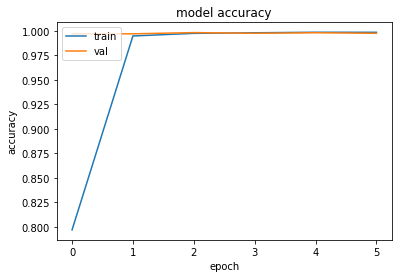

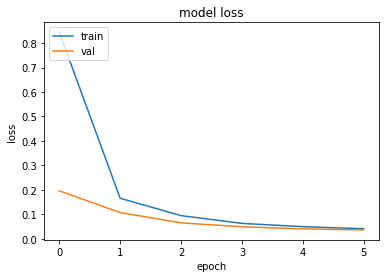

In [21]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
results = model.evaluate(test_ds, test_lb)

print(results)

5600/5600 [==============================] - 3s 612us/sample - loss: 0.0374 - acc: 0.9973
[0.0374240819471223, 0.9973214]


In [0]:
predictions = model.predict(test_ds)
cat_tit_dict = get_category_title_dict('/content/CA_category_id.json')
cat_tit_dict.update(get_category_title_dict('/content/US_category_id.json'))
cat_tit_dict.update(get_category_title_dict('/content/GB_category_id.json'))

In [0]:
def one_hot_to_index(one_hot):
    i_tags = []
    for i, b in enumerate(one_hot):
        if b == 1.0:
          i_tags.append(i)      
    return i_tags

def index_to_tag(i_tags):
  w_tags = []
  reversed_vocab_dict = {i: vo for vo, i in voc_di.items()}
  for index in i_tags:
      w_tags.append(reversed_vocab_dict[index])
  return w_tags


In [30]:
for i in range(30, 40):
    one_hot = one_hot_to_index(test_ds.values[i])
    tags_i = index_to_tag(one_hot)
    print(tags_i)
    print('predict:{}'.format(cat_tit_dict[str(np.argmax(predictions[i]))]))
    print('true label:{}'.format(cat_tit_dict[str(test_lb.values[i])]))

NameError: ignored

# Classifying using tags, number of likes and number of comments


In [0]:
full_dataframe = load_dataframe(csvpath, ['tags', 'likes', 'comment_count', 'category_id'])
max_of_tags = 25

full_dataframe = create_seperate_columns(full_dataframe, max_of_tags, 'tags')

full_dataframe.head()